In [4]:
from utils import *
from update_scores_and_fixtures import add_current_points

import pandas as pd

def build_simulation_data():

    scores_and_fixtures = read_scores_and_fixtures()
    scores_and_fixtures = add_current_points(scores_and_fixtures)

    columns = ['SeasonTag', 'Jornada' ,'Venue', 'MetaEquipo', 'Opponent', 'Result', 'SeasonStage', 'Season Type', 'current_points']
    data = scores_and_fixtures[columns]
    data = data[(data.SeasonStage.isin(['Apertura', 'Clausura'])) & (data['Season Type'] != 'Reclassification') ]
    data = data[['SeasonTag', 'Jornada' ,'Venue', 'MetaEquipo', 'Opponent', 'Result', 'current_points']]
    return data

data = build_simulation_data()
    

/home/miguel/repos/Broodds/update_scores_and_fixtures.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsample.sort_values(by=['current_points','current_goals_difference','current_goals'], inplace=True, ascending=False)
/home/miguel/repos/Broodds/update_scores_and_fixtures.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsample.sort_values(by=['current_points','current_goals_difference','current_goals'], inplace=True, ascending=False)
/home/miguel/repos/Broodds/update_scores_and_fixtures.py:352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [67]:
from itertools import combinations


possible_results = ['W', 'D', 'L']

possible_venues = ['Home', 'Away']


def pairwise_combinations_dict(lst):
    """Generate a dictionary with pairwise combinations as keys and empty lists as values."""
    # Generate all pairwise combinations
    pairs = combinations(lst, 2)
    # Create dictionary with tuples as keys and empty lists as values
        
    return {pair: [] for pair in pairs}



teams = data.MetaEquipo.unique().tolist()

match_probabilities = pairwise_combinations_dict(teams)

match_combinations = list(match_probabilities.keys())


In [68]:
for match in match_combinations:
    metaequipo, opponent = match[0], name_mapping[match[1]]
    total_games = data[(data.MetaEquipo == metaequipo) & (data.Opponent == opponent)].dropna()
    
        
    for venue in possible_venues:
        for result in possible_results:
            result_games_pvenue = total_games[(total_games.Result == result) & (total_games.Venue == venue)]
    
            if len(result_games_pvenue) > 0:
                match_probabilities[match].append(result_games_pvenue.shape[0])
            else:
                match_probabilities[match].append(0)
    for result in possible_results:
        result_games = total_games[total_games.Result == result]

        if len(total_games) > 0:
            match_probabilities[match].append(result_games.shape[0])
        else:
            match_probabilities[match].append(1)

In [69]:
match_probabilities

{('America', 'Atlas'): [3, 2, 3, 5, 2, 1, 8, 4, 4],
 ('America', 'Cruz_Azul'): [4, 3, 1, 5, 1, 2, 9, 4, 3],
 ('America', 'Guadalajara'): [4, 2, 2, 3, 3, 1, 7, 5, 3],
 ('America', 'Leon'): [3, 2, 2, 1, 3, 4, 4, 5, 6],
 ('America', 'Monterrey'): [4, 4, 0, 2, 1, 5, 6, 5, 5],
 ('America', 'Pachuca'): [2, 2, 4, 4, 2, 1, 6, 4, 5],
 ('America', 'Puebla'): [4, 4, 0, 4, 2, 2, 8, 6, 2],
 ('America', 'Pumas_UNAM'): [4, 4, 0, 2, 4, 2, 6, 8, 2],
 ('America', 'Queretaro'): [3, 3, 2, 4, 3, 1, 7, 6, 3],
 ('America', 'Santos_Laguna'): [6, 1, 1, 3, 3, 1, 9, 4, 2],
 ('America', 'Tijuana'): [7, 1, 0, 3, 3, 2, 10, 4, 2],
 ('America', 'Toluca'): [4, 1, 2, 3, 2, 3, 7, 3, 5],
 ('America', 'UANL'): [5, 1, 2, 3, 3, 2, 8, 4, 4],
 ('America', 'Necaxa'): [4, 0, 3, 2, 4, 1, 6, 4, 4],
 ('America', 'Atletico'): [2, 0, 1, 4, 0, 0, 6, 0, 1],
 ('America', 'FC_Juarez'): [2, 0, 2, 3, 1, 0, 5, 1, 2],
 ('America', 'Mazatlan'): [2, 1, 0, 2, 0, 1, 4, 1, 1],
 ('Atlas', 'Cruz_Azul'): [3, 2, 3, 2, 2, 4, 5, 4, 7],
 ('Atlas', 'Gua

In [70]:
from scipy.stats import dirichlet, pareto

def calcular_probabilidades_bayesianas(equipo1, equipo2, venue, historico):
    # Datos históricos para el enfrentamiento
    if venue == "Home":
        results = historico.get((equipo1, equipo2), [0, 0, 0])[:3]
        if len(results) == 0:
            results = [1,1,1]
        if sum(results) == 0:
            results = [1,1,1]

    elif venue == "Away":
        results = historico.get((equipo1, equipo2), [0, 0, 0])[3:6]
        if len(results) == 0:
            results = [1,1,1]
        if sum(results) == 0:
            results = [1,1,1]

    else:
        results = historico.get((equipo1, equipo2), [0,0,0])[6:]
        if len(results) == 0:
            results = [1,1,1]
        if sum(results) == 0:
            results = [1,1,1]
        venue = "Home"

    victorias, empates, derrotas = results[0], results[1], results[2]
    
    # Parámetros de la distribución previa Dirichlet (prior)
    alpha_prior = np.array([1, 1, 1])
    
    # Datos observados (likelihood)
    datos_observados = np.array([victorias, empates, derrotas])
    
    # Parámetros de la distribución posterior Dirichlet (posterior)
    alpha_posterior = alpha_prior + datos_observados
    
    # Muestras de la distribución posterior
    posterior_samples = dirichlet(alpha_posterior).rvs(size=10000)
    return posterior_samples.mean(axis=0)

# Ajustar probabilidades según una distribución de Pareto
def ajustar_probabilidades_pareto(probabilidades, equipos, shape=1.16):
    pareto_factors = pareto.rvs(shape, size=len(equipos))
    pareto_factors /= pareto_factors.sum()  # Normalizar para que sumen 1

    adjusted_probabilities = {}
    for venue in possible_venues:
        for (equipo1, equipo2, venue), probs in probabilidades.items():
            idx1 = equipos.index(equipo1)
            idx2 = equipos.index(equipo2)
            factor1 = pareto_factors[idx1]
            factor2 = pareto_factors[idx2]
            
            # Ajustar las probabilidades manteniendo la relación de probabilidades original
            total = factor1 + factor2
            adjusted_win_prob = probs[0] * (factor1 / total)
            adjusted_draw_prob = probs[1]  # No ajustar empate
            adjusted_loss_prob = probs[2] * (factor2 / total)
            
            adjusted_probabilities[(equipo1, equipo2, venue)] = [adjusted_win_prob, adjusted_draw_prob, adjusted_loss_prob]
    
    return adjusted_probabilities



probabilidades = { 
    (equipo1, equipo2, venue): calcular_probabilidades_bayesianas(equipo1, equipo2, venue, match_probabilities)
    for equipo1 in teams for equipo2 in teams for venue in possible_venues if equipo1 != equipo2
}

# Ajustar las probabilidades
# probabilidades = ajustar_probabilidades_pareto(probabilidades, teams)


In [71]:
jornadas_df = pd.read_csv('jornadas_ap_2024 .csv')
jornadas_df['Venue'] = 'Home'

In [72]:

jornadas = []

for jornada in range(1,18):
    jornada_matches = jornadas_df[jornadas_df.Jornada == jornada]
    list_of_matches = []
    for i in range(len(jornada_matches)):
        jornada_tuple = (jornada_matches.iloc[i].MetaEquipo, jornada_matches.iloc[i].Opponent)
        list_of_matches.append(jornada_tuple)
    jornadas.append(list_of_matches)
    

In [73]:
# Función para simular un partido entre dos equipos con probabilidades específicas
def simular_partido(equipo1, equipo2, venue):
    venue = venue if venue in ["Home", 'Away'] else "Home"
    prob = probabilidades[(equipo1, equipo2, venue)]
    prob = list(map(lambda x: x/sum(prob), prob))
    resultado = np.random.choice(["W", "D", "L"], p=prob)
    if resultado == "W":
        return (3, 0)
    elif resultado == "D":
        return (1, 1)
    else:
        return (0, 3)

In [74]:
# Simulación
equipos = teams
num_simulaciones = 1000



simulaciones = {equipo: [] for equipo in equipos}

for _ in range(num_simulaciones):
    puntos_temporada = {equipo: 0 for equipo in equipos}
    
    for jornada in jornadas:
        for (equipo1, equipo2) in jornada:
            puntos1, puntos2 = simular_partido(equipo1, equipo2, 'a')
            puntos_temporada[equipo1] += puntos1
            puntos_temporada[equipo2] += puntos2
    
    for equipo in equipos:
        simulaciones[equipo].append(puntos_temporada[equipo])

# Convertir los resultados a un DataFrame
resultados_df = pd.DataFrame(simulaciones)


In [96]:
forecast = resultados_df.quantile(0.8).to_dict()
forecast = {x : [y] for x,y in forecast.items()}
forecast = pd.DataFrame.from_dict(forecast).T
forecast = forecast.rename(columns={0:"points"})
for team in teams:
    forecast.loc[team, '+/-'] = resultados_df.describe().iloc[2,:][team]

forecast.to_csv("Forecast2.csv")

In [46]:
resultados_df.describe().iloc[2,:]['America']

4.952519202027029

In [14]:
higher_results = resultados_df.quantile(0.80).sort_values(ascending=False)
mean_results = resultados_df.quantile(0.50).sort_values(ascending=False)

In [49]:
pareto_forecast = {team : [higher_results[team]] if team in higher_results.iloc[:8].index else [mean_results[team]] for team in teams}
pareto_forecast = pd.DataFrame.from_dict(pareto_forecast).T
pareto_forecast = pareto_forecast.rename(columns={0: 'points'})
pareto_forecast['+/-'] = 0

for team in teams:
    pareto_forecast.loc[team, '+/-'] = resultados_df.describe().iloc[2,:][team]

# pareto_forecast['margin_error'] = pareto_forecast.apply(lambda row: row)

In [51]:
pareto_forecast.sort_values(by='points', ascending=False).to_csv('Forecast2.csv')

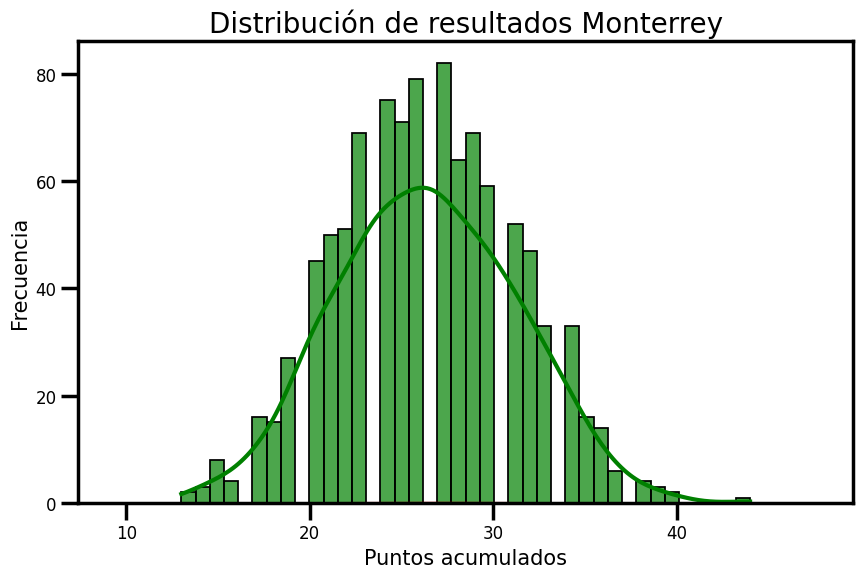

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

team = 'Monterrey'

# Suponemos que ya tienes un DataFrame `df` y una columna 'column_x'
# df = pd.read_csv('your_data.csv') # Por ejemplo, si necesitas cargar los datos

sns.set_context("poster")

# Crear la figura y los ejes
plt.figure(figsize=(10, 6))

# Crear el histograma con Matplotlib
sns.histplot(resultados_df[team], kde=True, color='green', bins=40, edgecolor='black', alpha=0.7)

# Agregar la línea suavizada con Kernel Density Estimate (KDE)
sns.kdeplot(resultados_df[team], color='red', linewidth=1)

# Mejorar la estética del gráfico
plt.title(f'Distribución de resultados {team}', fontsize=20)
plt.xlabel('Puntos acumulados', fontsize=15)
plt.ylabel('Frecuencia', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()